In [1]:
import numpy as np
import logging 
import time 
from datetime import datetime
import json
from pathlib import Path

from src import ParameterSet, Plot
from src import ModelBase as Model
from src.integral import itoint

from src.model_base import ModelBase
import matplotlib.pyplot as plt

# np.seterr(all='raise')
np.set_printoptions(precision=4, suppress=True, linewidth=200)
logging.basicConfig(level=logging.WARN)

In [2]:
def run(t_end, changes = {}, *, dt=0.001, path:Path=None):
    print(f'estimated time: {1.1 * t_end/dt / 1000} seconds')
    t_start = time.time()
    t = np.linspace(0, t_end, int(t_end / dt) + 1)
    y0 = Model()
    y0.initialize()
    params = ParameterSet("structure.json")
    params.batch_update(changes)
    params.J.print_matrix()
    params.J_ampa.print_matrix()
    print(json.dumps(params.__flat_json__(ignore_zeros=True), indent=2))
    if path is not None:
        params.save(path / 'params.json')
        params.saveDelta(path / 'params_delta.json',base_file='structure.json')
        params.saveDeltaHtml(path / 'params_delta.html',base_file='structure.json')
        params.saveHtml(path / 'params.html',keys = ["exc1.Iback"])

    def calc_g_static():
      sigma = y0.serialize_g(params)
      g_vector = sigma * params.constants.tau_y
      g_matrix = np.diag(g_vector)
      g_matrix = g_matrix[:,~np.all(g_matrix == 0, axis=0)]
      g_matrix = g_matrix * 1.0
      return g_matrix
    
    g_matrix = calc_g_static()

    def model_f(y, t):
        Y = Model().deserialize(y)
        delta = Y.calcDelta(t, params)
        dy = delta.serialize()
        return dy

    def model_g(y, t):
        # Y = MyState().deserialize(y)
        # sigma = Y.serialize_g(params)
        # tau_y = params.constants.tau_y
        # g = sigma * tau_y
        # return np.diag(g_vector)
        return g_matrix.copy()

    # gen = np.random.Generator(np.random.PCG64(123))
    gen = None
    # res = sdeint.itoint(model_f, model_g, y0.serialize(), t, gen)
    res = itoint(model_f, model_g, y0.serialize(), t, gen)
    def toState(y): return Model().deserialize(y)
    t_end = time.time()
    print(f'elapsed time: {t_end - t_start} seconds')
    return t, list(map(toState, res))

In [3]:
new_params = {"sst1.I_back.dc": 0.25,"sst2.I_back.dc": 0.25,
                "vip1.I_back.type": "sin", "vip1.I_back.amplitude": 0.1, 
                "vip1.I_back.frequency": 4, "vip2.I_back.type": "sin", 
                "vip2.I_back.amplitude": 0.1, "vip2.I_back.frequency": 4,
                "exc1.I_back.amplitude": 0., "exc1.I_back.frequency": 0,
                "exc2.I_back.amplitude": 0.,"exc2.I_back.frequency": 0}


estimated time: 11.0 seconds
                exc1      exc2        pv      sst1      sst2      vip1      vip2
      exc1     0.481     0.011    -0.360    -0.450                              
      exc2     0.011     0.481    -0.360              -0.450                    
        pv     0.301     0.301    -0.120                                        
      sst1     0.350                                            -0.350          
      sst2               0.350                                            -0.350
      vip1     0.450                        -0.350                              
      vip2               0.450                        -0.350                    
                exc1      exc2        pv      sst1      sst2      vip1      vip2
      exc1     3.040     1.400                                                  
      exc2     1.400     3.040                                                  
        pv     2.560     2.560                                                  

C:\Users\palavia\AppData\Local\Temp\ipykernel_7812\3623514589.py:7: ResourceWarning: unclosed file <_io.TextIOWrapper name='structure.json' mode='r' encoding='cp1252'>
  params = ParameterSet("structure.json")
c:\Users\palavia\neural-simulation\src\param.py:69: ResourceWarning: unclosed file <_io.TextIOWrapper name='structure.json' mode='r' encoding='cp1252'>
  base = ParameterSet(base_file).__flat_json__()
c:\Users\palavia\neural-simulation\src\model_base.py:69: RuntimeWarning: overflow encountered in exp
  den = 1 - np.exp(-p.d * num)
c:\Users\palavia\neural-simulation\src\model_base.py:107: RuntimeWarning: overflow encountered in scalar multiply
  gamma_r *= (1-n.s)
c:\Users\palavia\neural-simulation\src\model_base.py:47: RuntimeWarning: invalid value encountered in scalar multiply
  n_dest._input += n_src.s * p.J.get(src, dest)
c:\Users\palavia\neural-simulation\src\integral.py:94: RuntimeWarning: invalid value encountered in add
  Yn1 = Yn + 0.5*(fnh + fn1h) + dg
c:\Users\palavia\

elapsed time: 4.528257608413696 seconds
ozkurt... 
canolty... 
tort... 


IndexError: index 18 is out of bounds for axis 0 with size 18

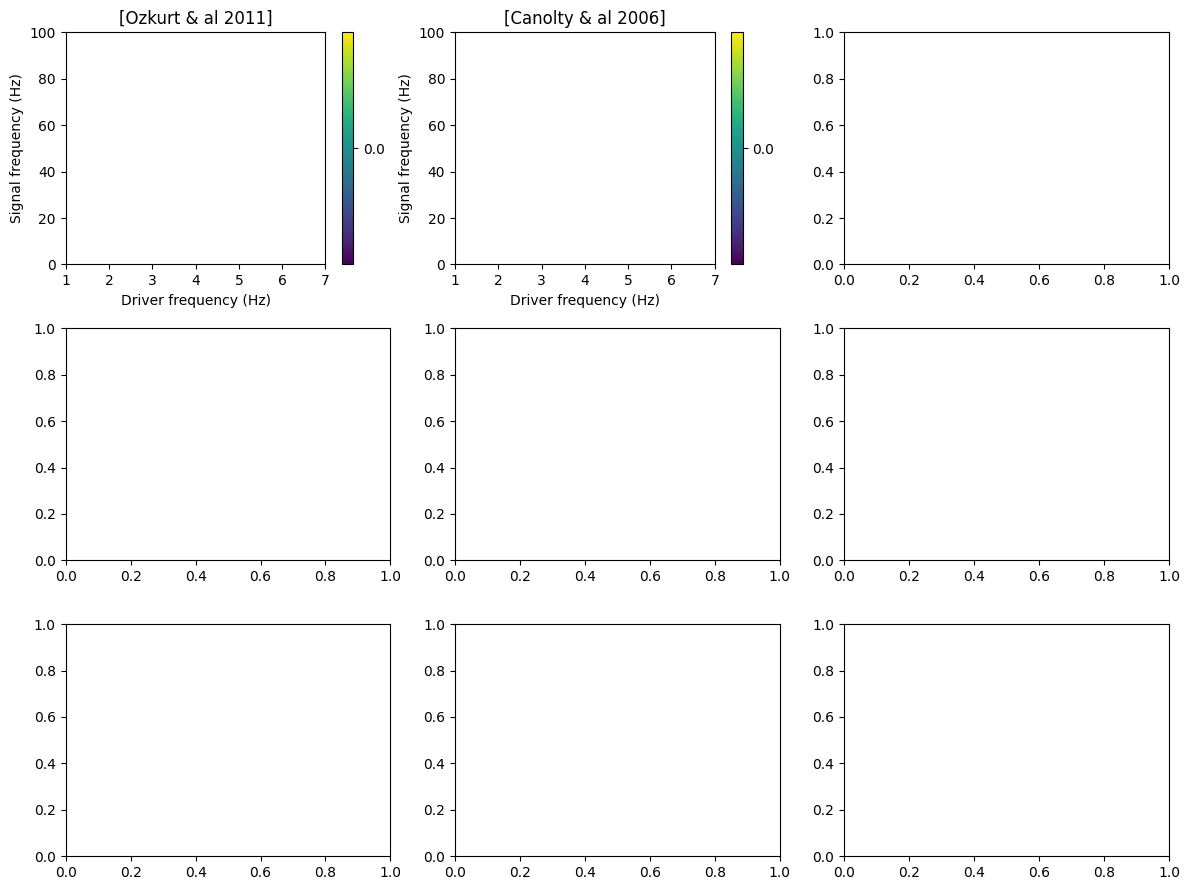

In [5]:
experiments = [{"pv.opto":0.75}]
if __name__ == '__main__':
    exp = 'opto_pv'
    for experiment in experiments:
        experiment.update()
        dt = datetime.now()
        folder = Path(f'img/{exp}/{dt.strftime("%Y-%m-%d")}/{dt.strftime("%H%M%S")}')
        folder.mkdir(parents=True)
        t, res = run(10, changes = experiment , dt=0.001, path=folder)
        #exc1_r = np.array([x.exc1.r for x in res])
        plots = [
            Plot(['exc1.r'], t_start=0, t_end=10, title='Exc 1 Firing Rate', file=folder / 'r1.svg'),
            Plot(['exc2.r'], t_start=0, t_end=10, title='Exc 2 Firing Rate', file=folder / 'r2.svg'),
            Plot(['pv.r'],   t_start=0, t_end=10, title='PV Firing Rate',    file=folder / 'pv.svg'),
            Plot(['sst1.r'], t_start=0, t_end=10, title='SST 1 Firing Rate', file=folder / 's1.svg'),
            Plot(['sst2.r'], t_start=0, t_end=10, title='SST 2 Firing Rate', file=folder / 's2.svg'),
            Plot(['vip1.r'], t_start=0, t_end=10, title='VIP 1 Firing Rate', file=folder / 'v1.svg'),
            Plot(['vip2.r'], t_start=0, t_end=10, title='VIP 2 Firing Rate', file=folder / 'v2.svg'),
            Plot(['exc1.r'], t_start=0, t_end=10, title='Exc 1 PAC', file=folder / 'pac.svg',plot_type= "pac")
            Plot(['exc1.r'], t_start=0, t_end=10, title='Exc 1 fft', file=folder / 'fft.svg',plot_type= "fft")
            # Plot(['exc1.r'], t_start=2, t_end=3, title='Exc 1 Firing Rate', file=f'{folder}/r1-before.png'),
            # Plot(['exc1.r'], t_start=5, t_end=6, title='Exc 1 Firing Rate', file=f'{folder}/r1-during.png'),
            # Plot(['exc1.r'], t_start=7, t_end=8, title='Exc 1 Firing Rate', file=f'{folder}/r1-after.png'),
            # Plot(['exc1.r','exc2.r','pv.r'], t_start=3, t_end=7, title='Exc 1, 2, PV Firing Rate', file=f'{folder}/r1-r2.png'),
        ]
        for p in plots:
            p(t,res)
        plots_ref = [p.file.name for p in plots]
        plots_ref = [f'<div class="res-img"><img src="{p}"/></div>' for p in plots_ref]
        plots_ref = '\n'.join(plots_ref)

        html = folder / 'results.html'
        html.write_text(f'''<html>
    <head>
        <title> Summary </title>
        <style>
        .images {{display: flex; flex-wrap: wrap;}}
        .res-img {{}}
        </style>
    </head>
    <body>
    <section id="inputs">
        <iframe src="params.html" onload='javascript:(function(o){{o.style.height=o.contentWindow.document.body.scrollHeight+"px";}}(this));' 
        style="height:200px;width:100%;border:none;overflow:hidden;"></iframe>
        <iframe src="params_delta.html" onload='javascript:(function(o){{o.style.height=o.contentWindow.document.body.scrollHeight+"px";}}(this));' 
        style="height:200px;width:100%;border:none;overflow:hidden;"></iframe>
    </section>
    <section id="results">
        <div class="images">{plots_ref}</div>
    </section>
    </body>
    </html>''')

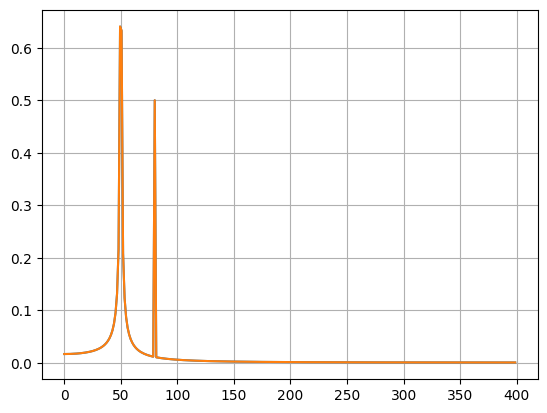

c:\Users\palavia\neural-simulation\venv\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


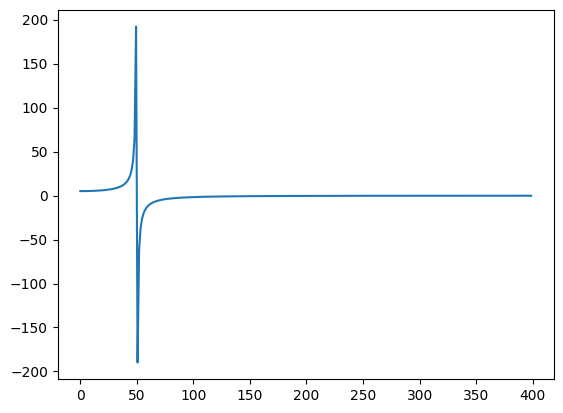

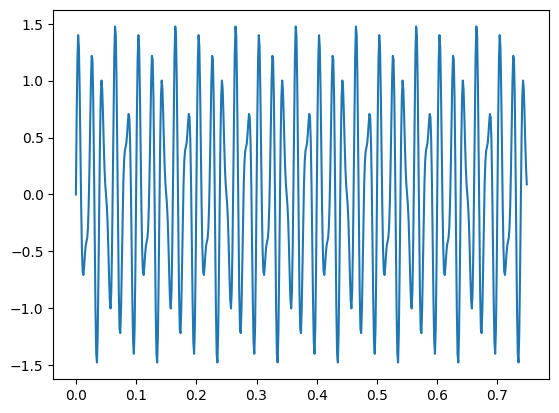

In [16]:
from scipy.fft import fft, fftfreq
import numpy as np
# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
xf = fftfreq(N, T)[:N//2]
xf2= fftfreq(len(x), x[1]-x[0])[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.plot(xf2, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()
plt.plot(xf,yf[0:N//2])
plt.show()
plt.plot(x,y)

In [15]:

x[1]-x[0]

0.00125

In [11]:
T

0.00125